In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

sns.set_theme(style='darkgrid')
colors = sns.color_palette('bright')

plt.rc('axes', titlesize=20) # fontsize of the axes title
plt.rc('axes', labelsize=18) # fontsize of the x and y labels
plt.rc('xtick', labelsize=16) # fontsize of the tick labels
plt.rc('ytick', labelsize=16) # fontsize of the tick labels
plt.rc('legend', fontsize=18) # legend fontsize
plt.rc('font', size=13) # controls default text sizes

plt.rcParams.update({'font.size': 15})

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Importing plotly failed. Interactive plots will not work.


### Walmart DF

In [3]:
walmart_df = pd.read_csv('data/walmart_cleaned.csv').drop('Unnamed: 0', axis=1)

In [4]:
walmart_df.head()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [5]:
walmart_df.shape

(421570, 16)

### Weekly Sales for Store 1

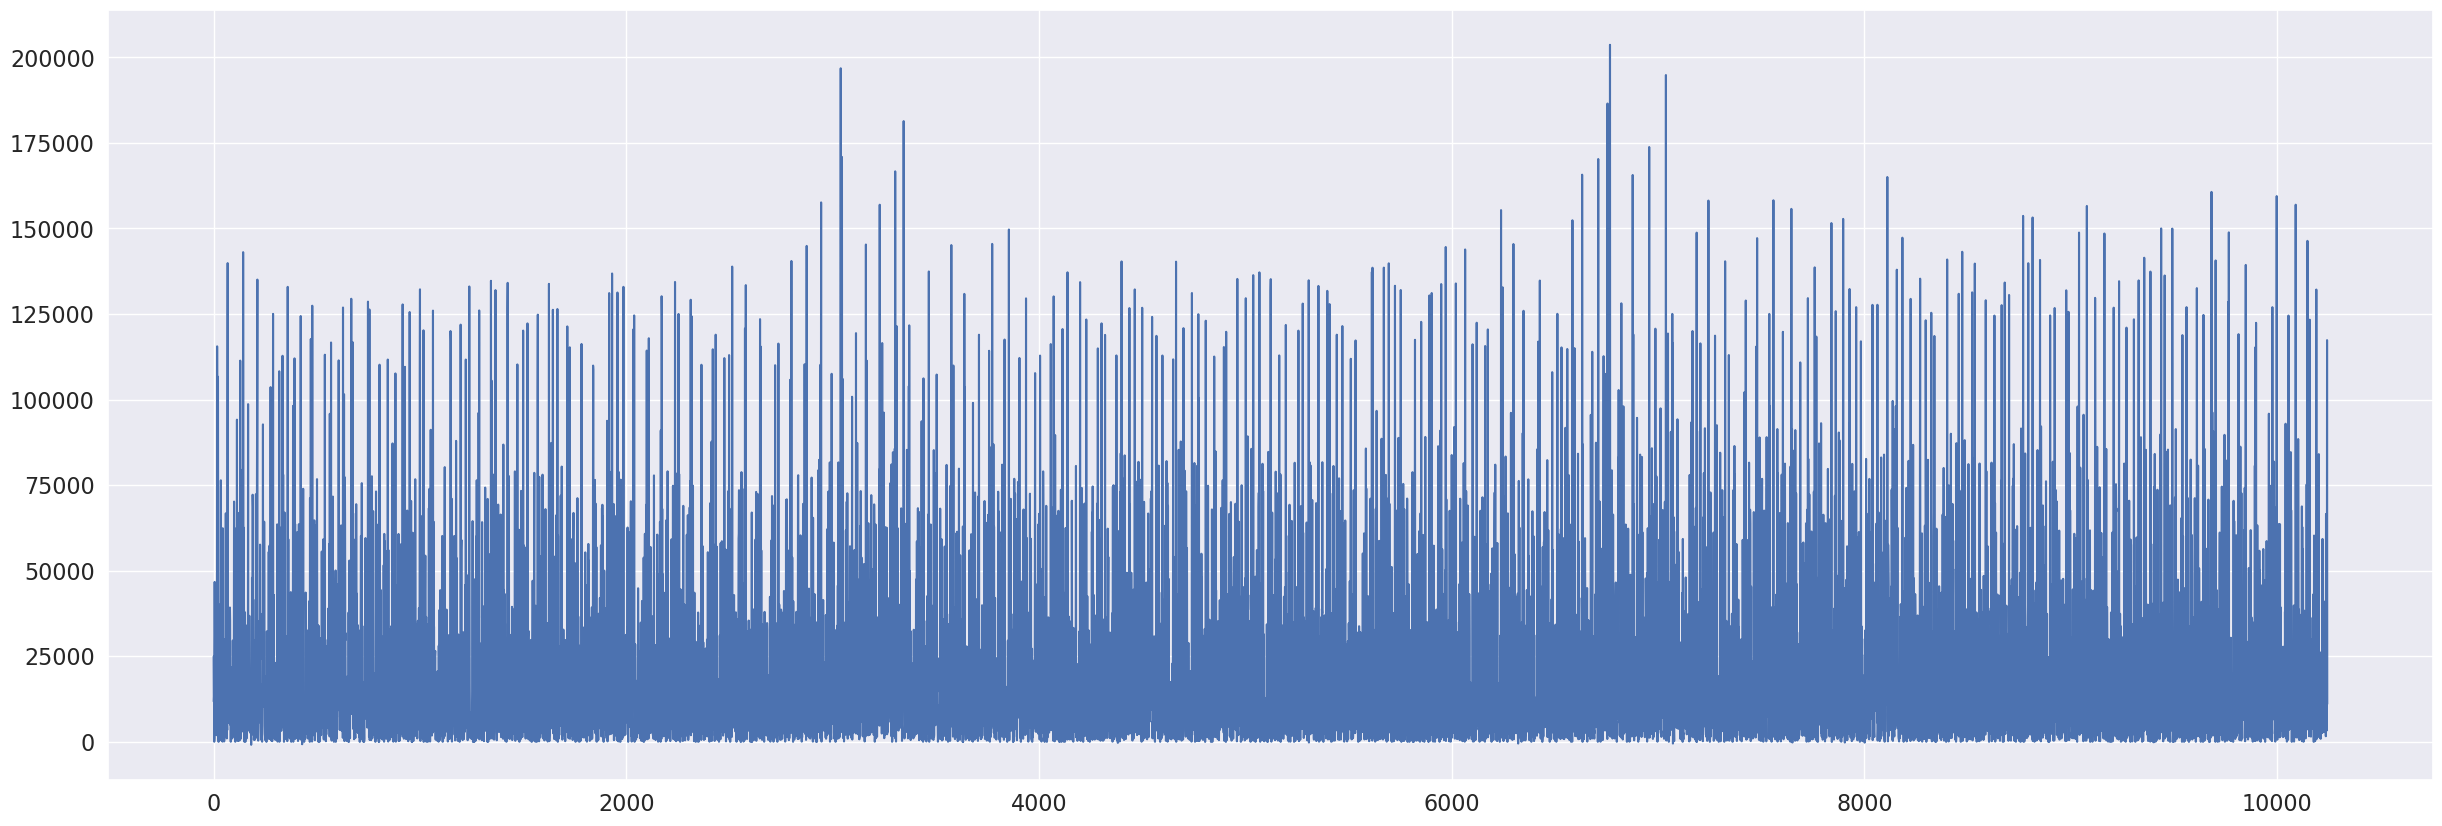

In [6]:
plt.rcParams['figure.figsize']=[30,10]

walmart_store_one = walmart_df[walmart_df['Store'] == 1]
walmart_store_one = walmart_store_one[['Date', 'Weekly_Sales']]
plt.plot(walmart_store_one['Weekly_Sales'])

In [7]:
walmart_store_one['Date'] = pd.to_datetime(walmart_store_one['Date'])

In [9]:
walmart_store_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10244 entries, 0 to 10243
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          10244 non-null  datetime64[ns]
 1   Weekly_Sales  10244 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 240.1 KB


### Resample Data by Day

In [10]:
walmart_store_one = walmart_store_one.set_index('Date').resample('D').mean()
walmart_store_one = walmart_store_one.reset_index()
walmart_store_one['Weekly_Sales'] = walmart_store_one['Weekly_Sales'].interpolate()

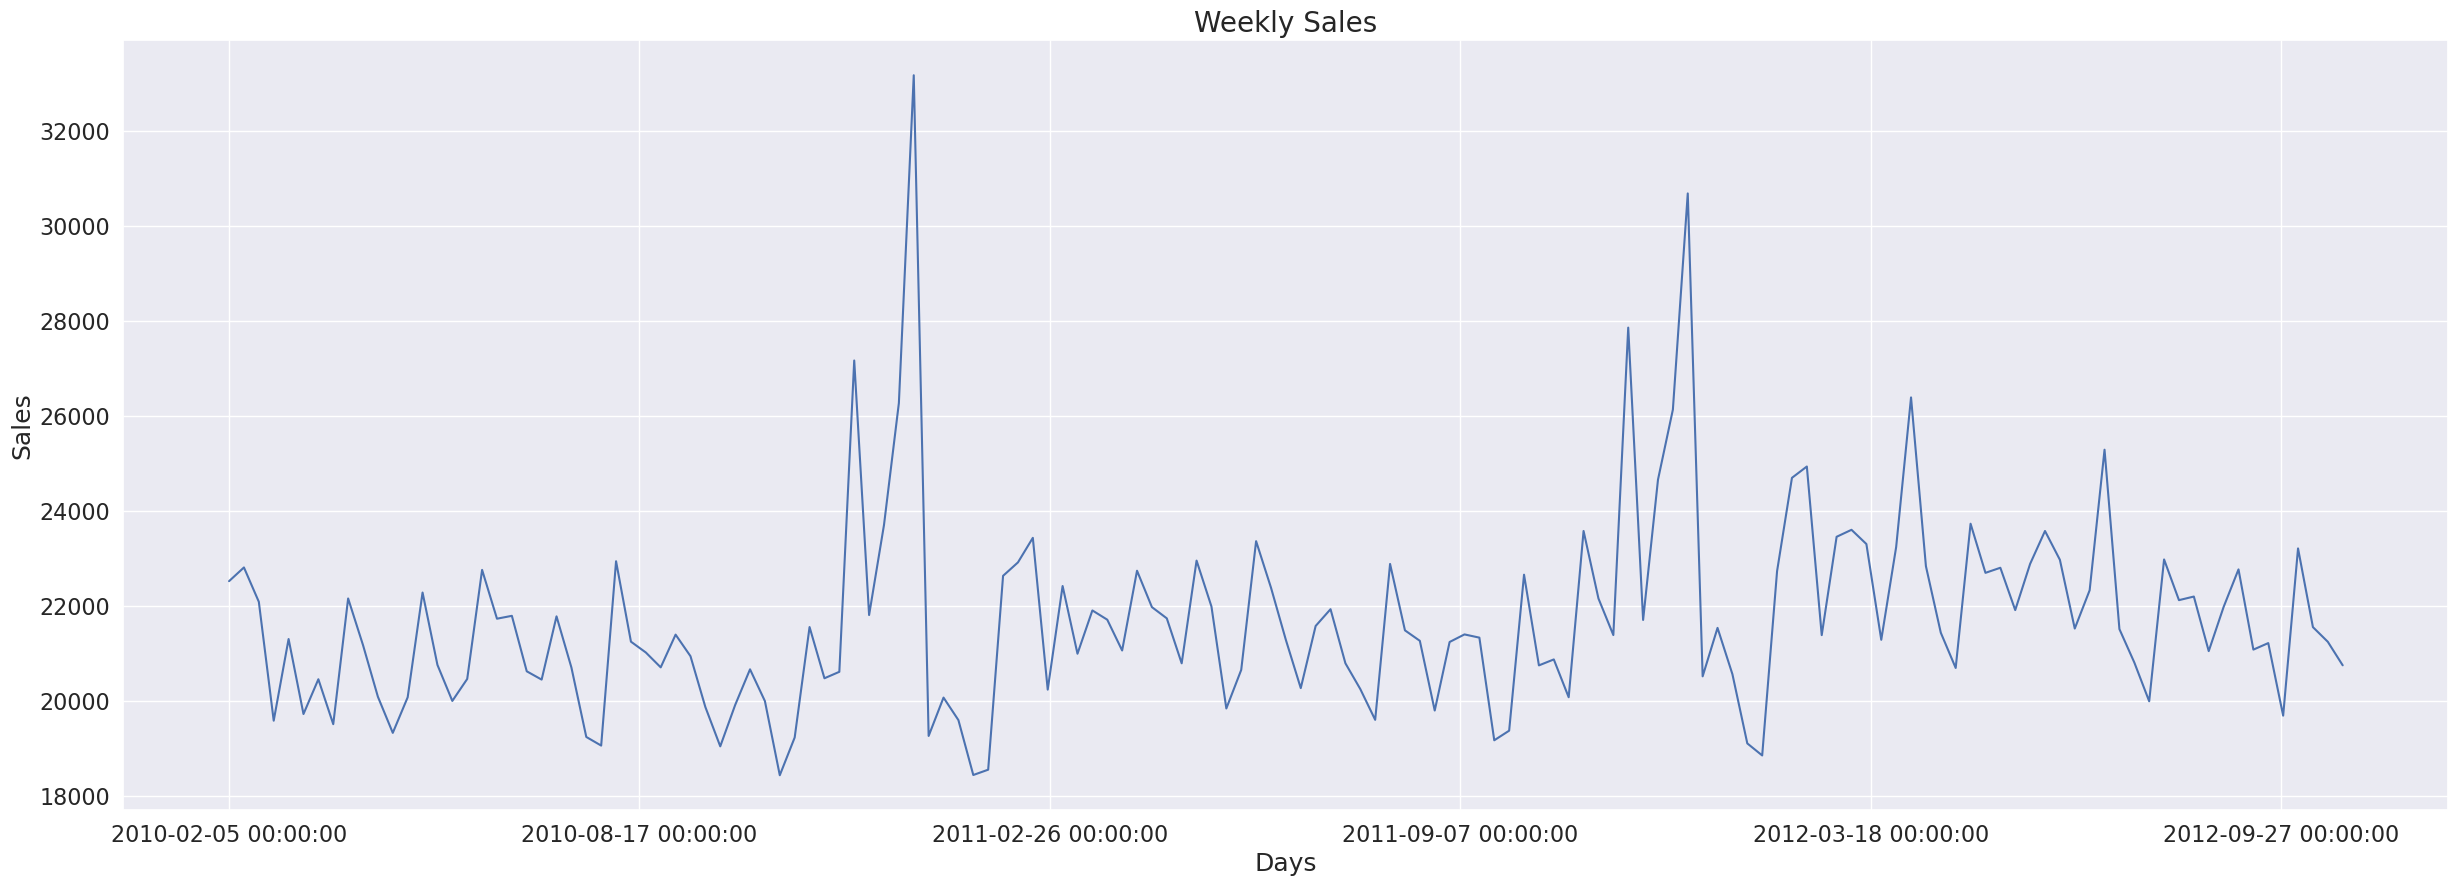

In [12]:
# Plot Resampled Weekly Sales Data
plt.plot(walmart_store_one['Weekly_Sales'])
plt.xticks(range(0, 1158, 193), walmart_store_one['Date'][range(0, 1158, 193)])
plt.xlabel('Days')
plt.ylabel('Sales')
plt.title('Weekly Sales')
plt.show()

### Autocorrelation and Partial Autocorrelation

In [2]:
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

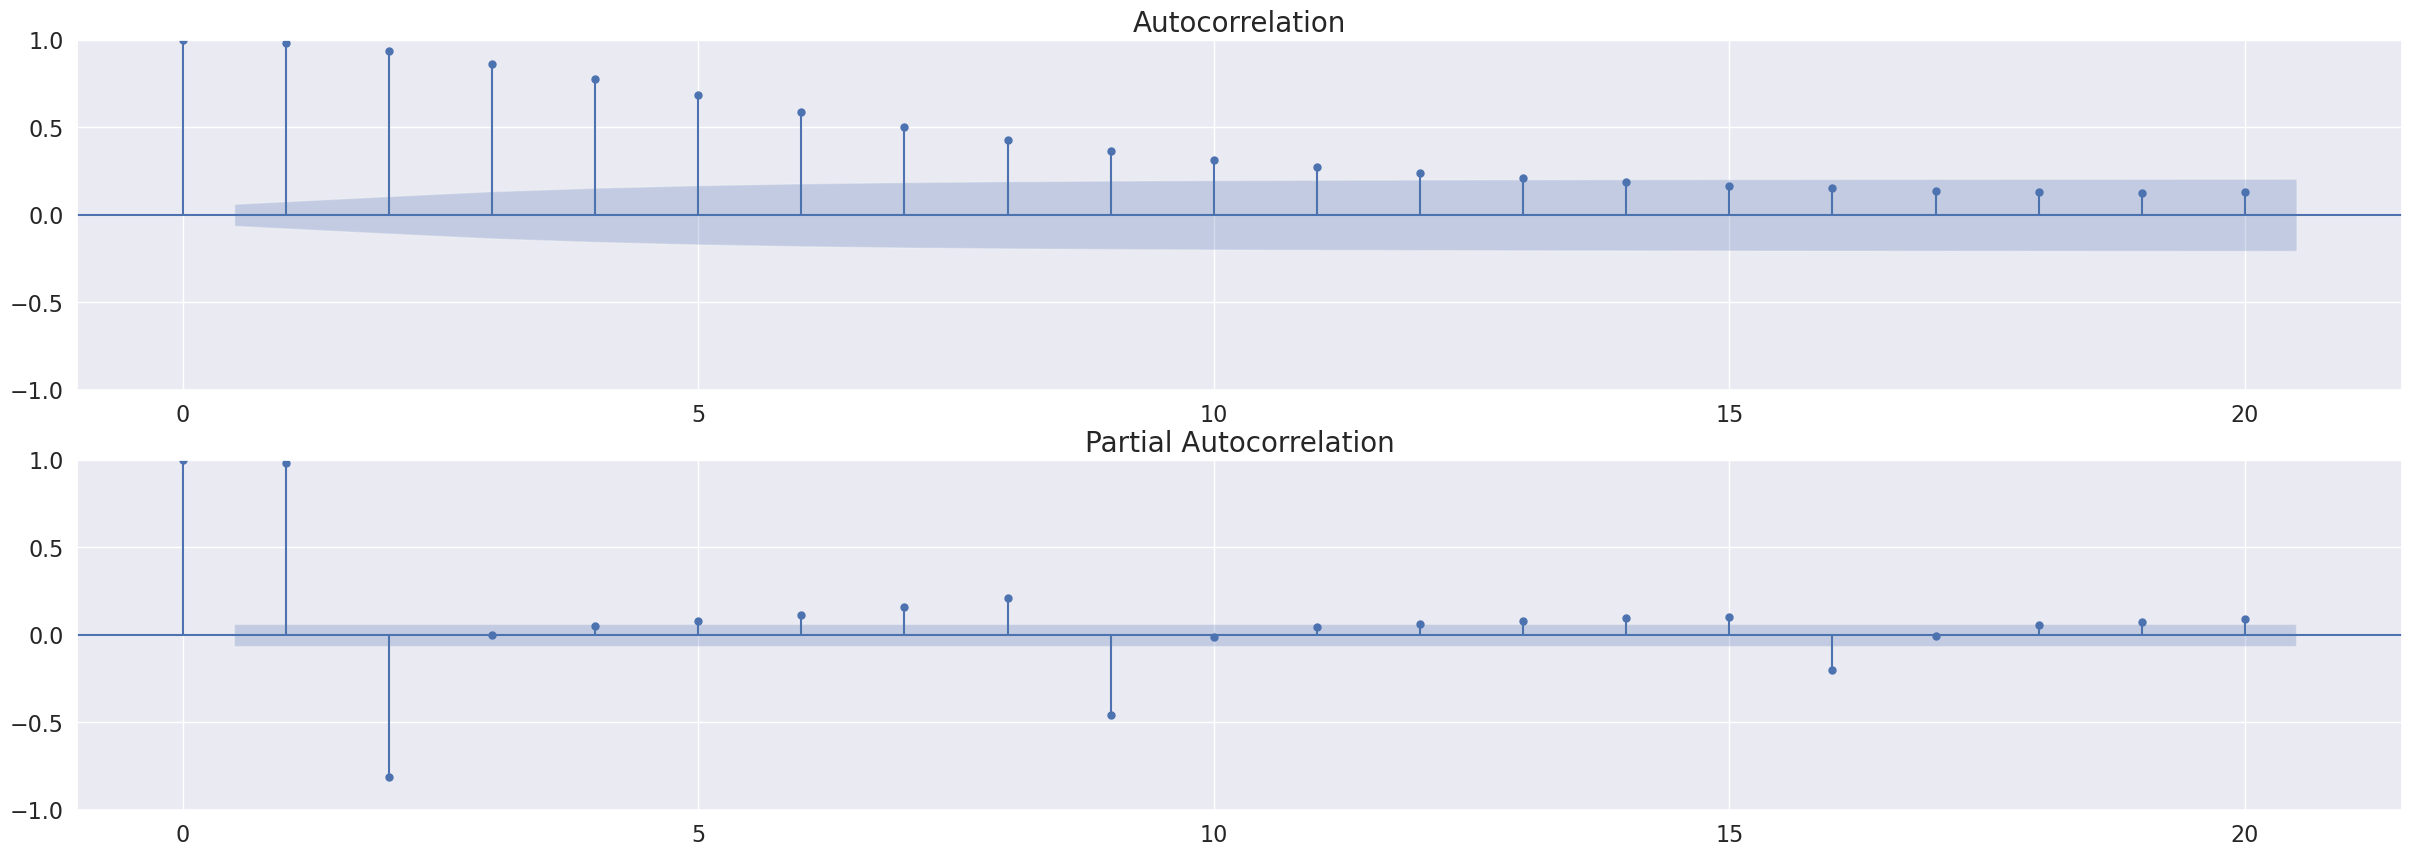

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(walmart_store_one['Weekly_Sales'], lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(walmart_store_one['Weekly_Sales'], method='ywmle', lags=20, ax=plt.gca())
plt.show()

### Holiday Events
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [14]:
# Holidays Table
super_bowl = pd.DataFrame({
  'holiday': 'super_bowl',
  'ds': pd.to_datetime(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']),
  'lower_window': 0,
  'upper_window': 1,
})

labour_day = pd.DataFrame({
  'holiday': 'labour_day',
  'ds': pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']),
  'lower_window': 0,
  'upper_window': 1,
})

thanksgiving = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']),
  'lower_window': 0,
  'upper_window': 1,
})

christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((super_bowl, labour_day, thanksgiving, christmas))

In [16]:
holidays.head()

,holiday,ds,lower_window,upper_window
0,super_bowl,2010-02-12,0,1
1,super_bowl,2011-02-11,0,1
2,super_bowl,2012-02-10,0,1
3,super_bowl,2013-02-08,0,1
0,labour_day,2010-09-10,0,1


### Train Data

In [17]:
walmart_store_one['Year'] = walmart_store_one['Date'].dt.year

In [18]:
walmart_store_one

,Date,Weekly_Sales,Year
0,2010-02-05,22516.313699,2010
1,2010-02-06,22557.549519,2010
2,2010-02-07,22598.785340,2010
3,2010-02-08,22640.021161,2010
4,2010-02-09,22681.256982,2010
...,...,...,...
990,2012-10-22,21028.206192,2012
991,2012-10-23,20957.473186,2012
992,2012-10-24,20886.740179,2012
993,2012-10-25,20816.007173,2012


In [19]:
walmart_store_one_train = walmart_store_one.loc[((walmart_store_one['Year'] == 2010) | (walmart_store_one['Year'] == 2011))]
walmart_store_one_train = walmart_store_one_train.drop(['Year'], axis=1)

### Prophet

In [23]:
walmart_store_one_train.columns = ['ds', 'y']

In [24]:
horizon = walmart_store_one.shape[0] - walmart_store_one_train.shape[0]

In [25]:
model_prophet = Prophet(growth='linear',
                        changepoint_range=0.8,
                        n_changepoints=35,
                        seasonality_mode = 'multiplicative',
                        holidays=holidays,
                        yearly_seasonality=True,
                        weekly_seasonality=True,
                        daily_seasonality=False,
                        seasonality_prior_scale=25,
                        changepoint_prior_scale=0.5,
                        interval_width=0.5)

model_prophet.fit(walmart_store_one_train)

17:24:31 - cmdstanpy - INFO - Chain [1] start processing
17:24:32 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
forecast = model_prophet.make_future_dataframe(periods=horizon)
forecast.tail()

,ds
990,2012-10-22
991,2012-10-23
992,2012-10-24
993,2012-10-25
994,2012-10-26


In [27]:
prediction = model_prophet.predict(forecast)

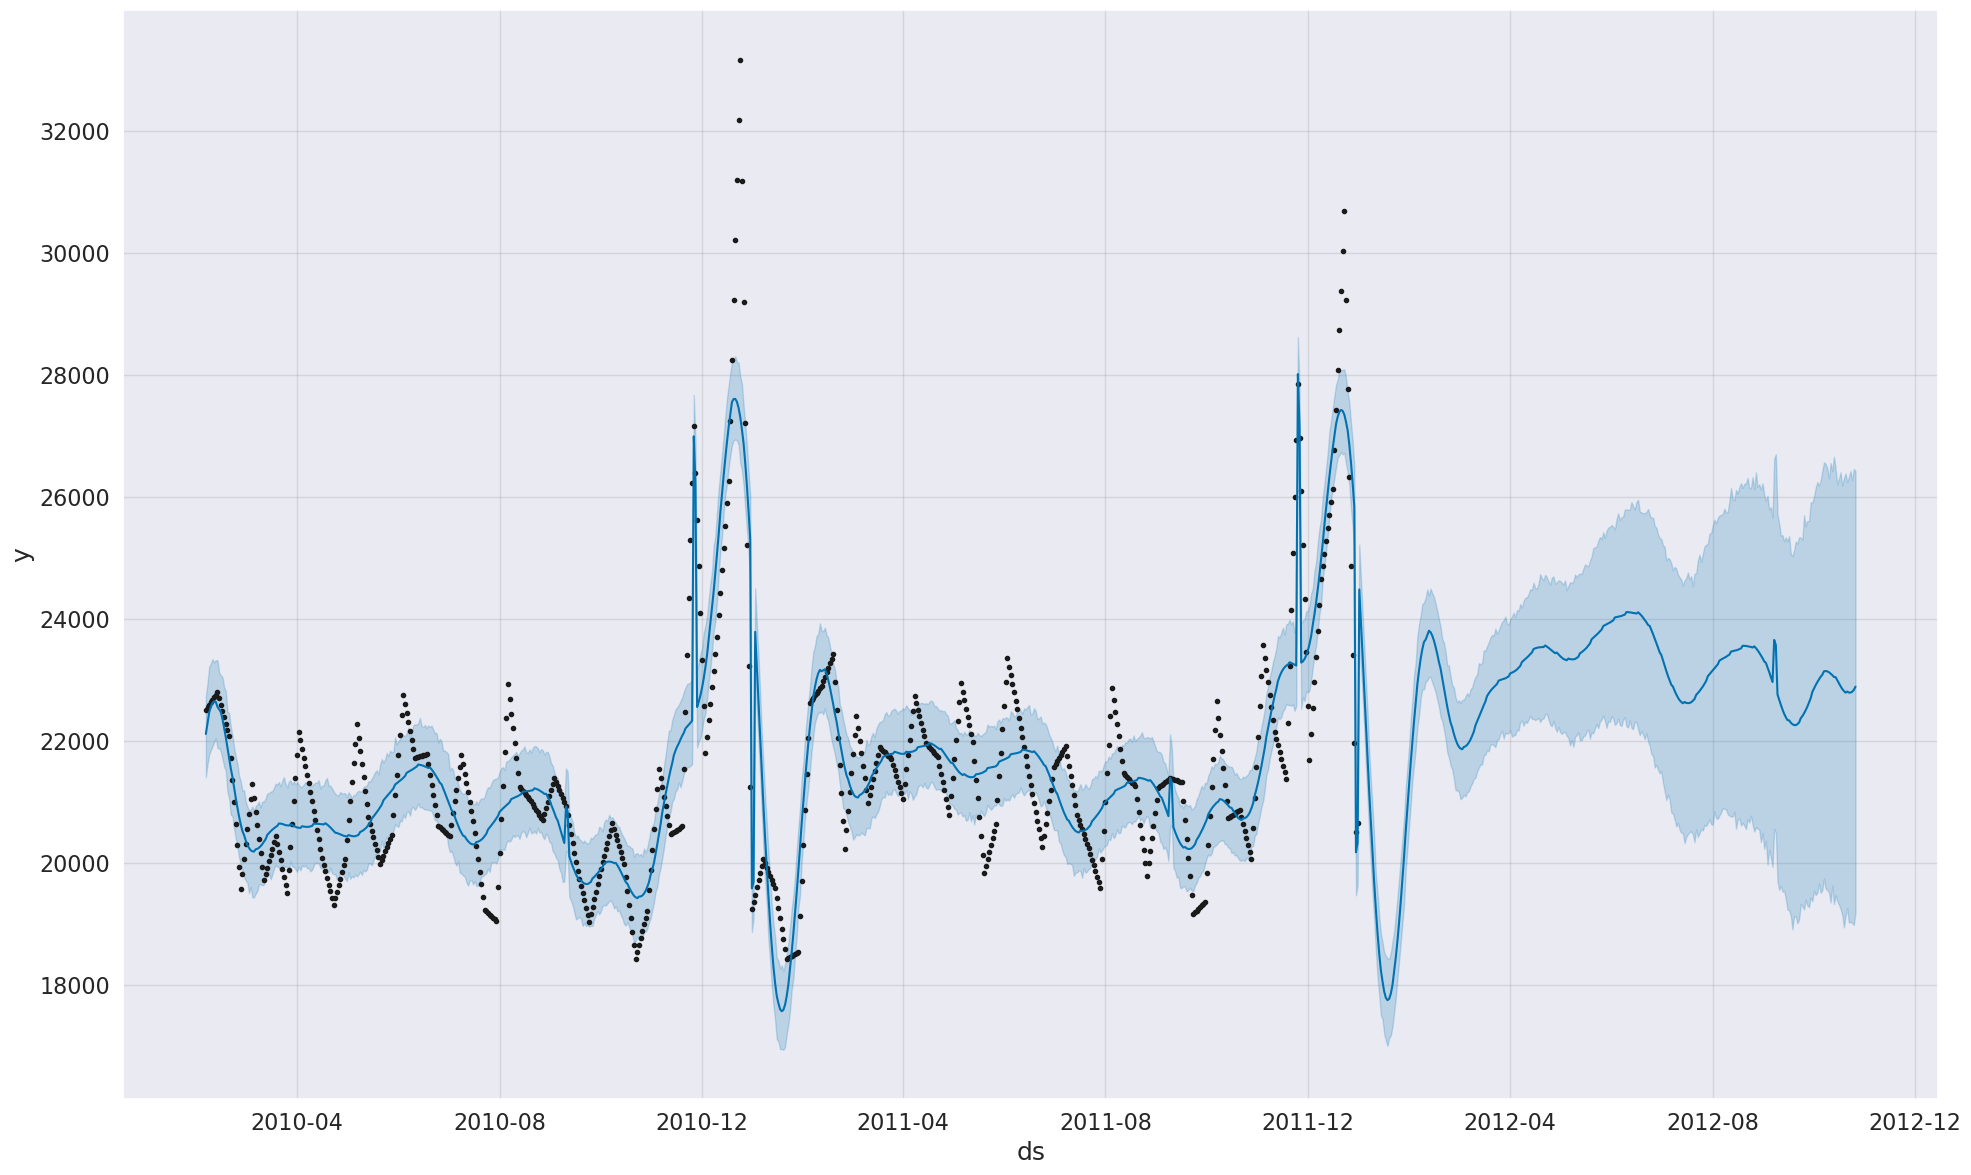

In [28]:
plt.rcParams['figure.figsize']=[30,10]
fig_1 = model_prophet.plot(prediction, figsize=(20, 12))

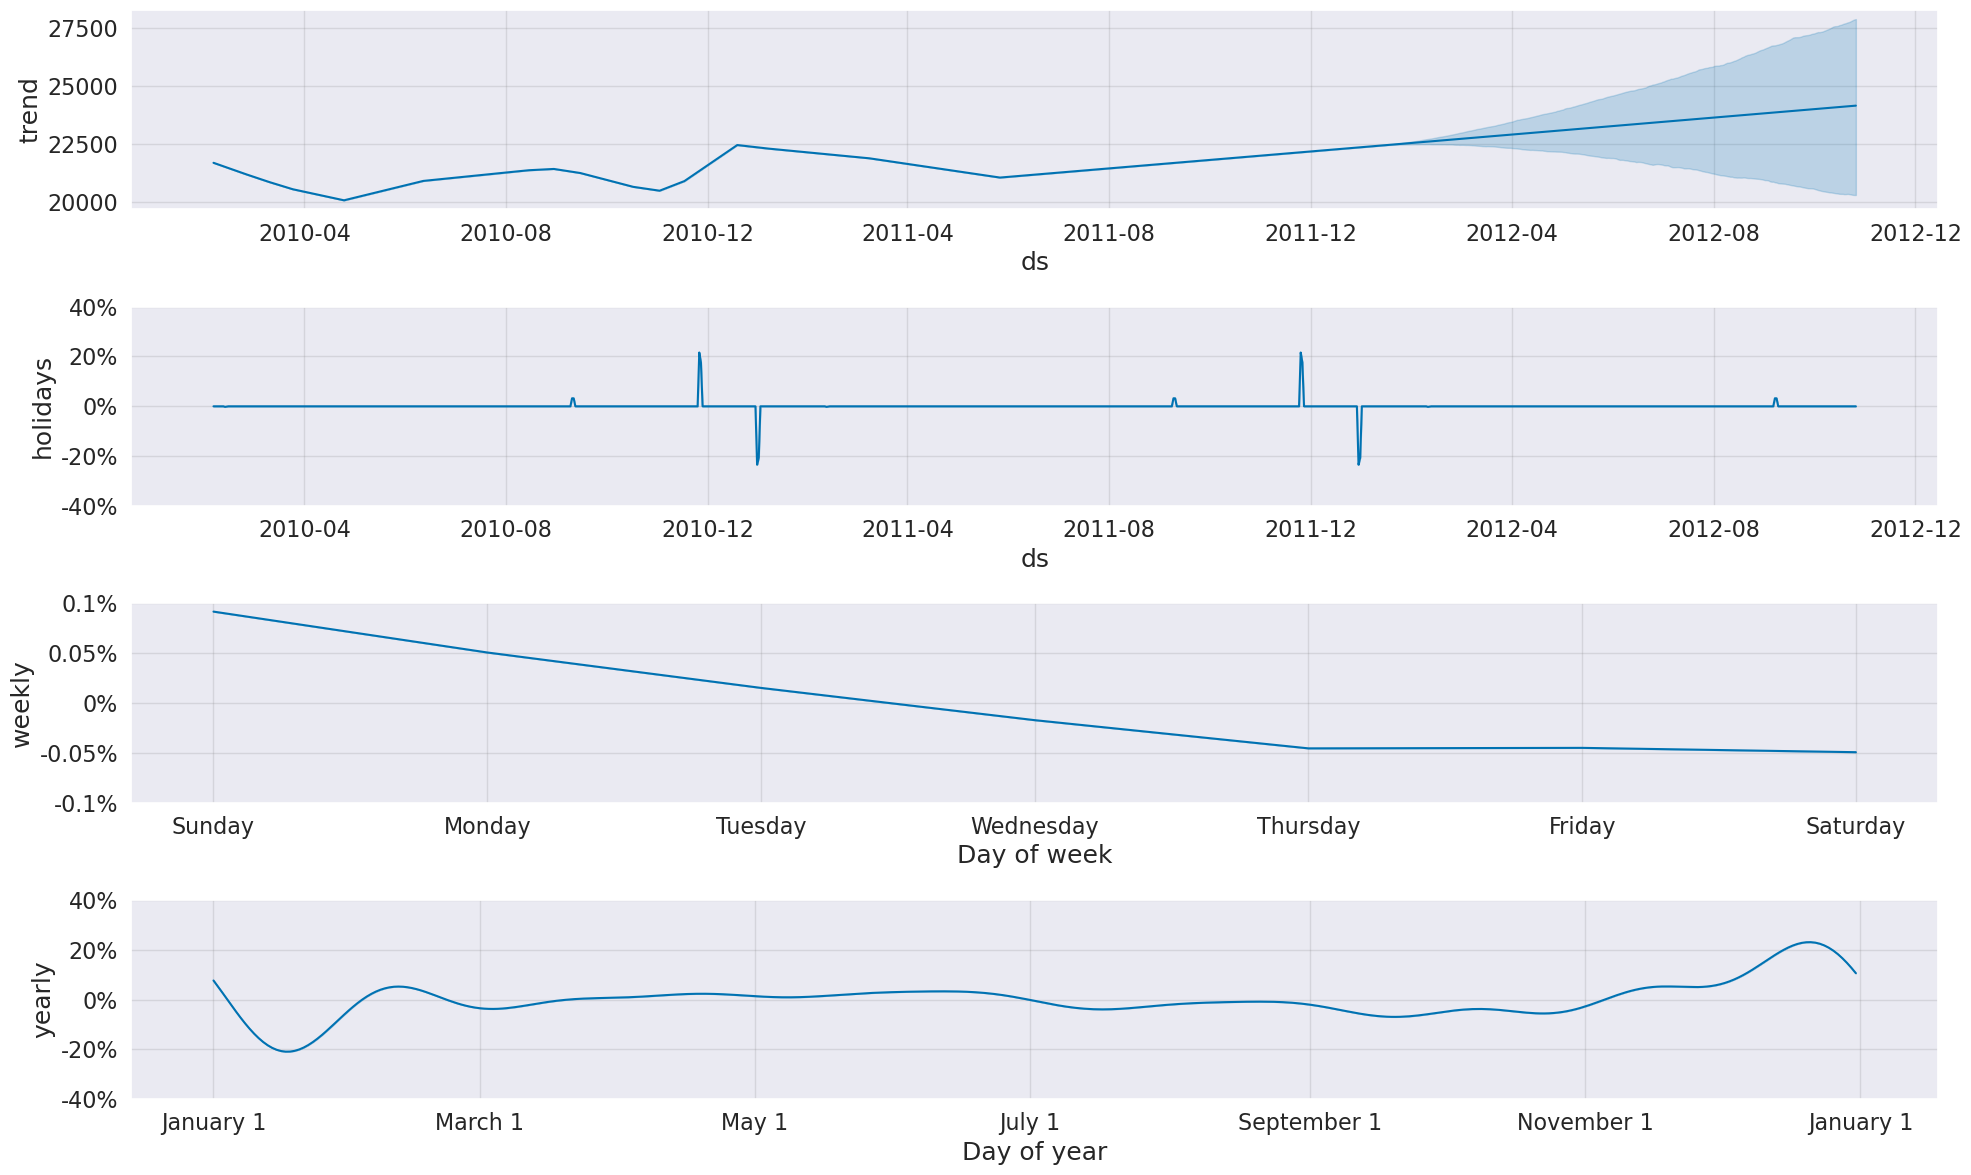

In [29]:
fig_2 = model_prophet.plot_components(prediction, figsize=(20, 12))

### Plot Real Data and Predicition

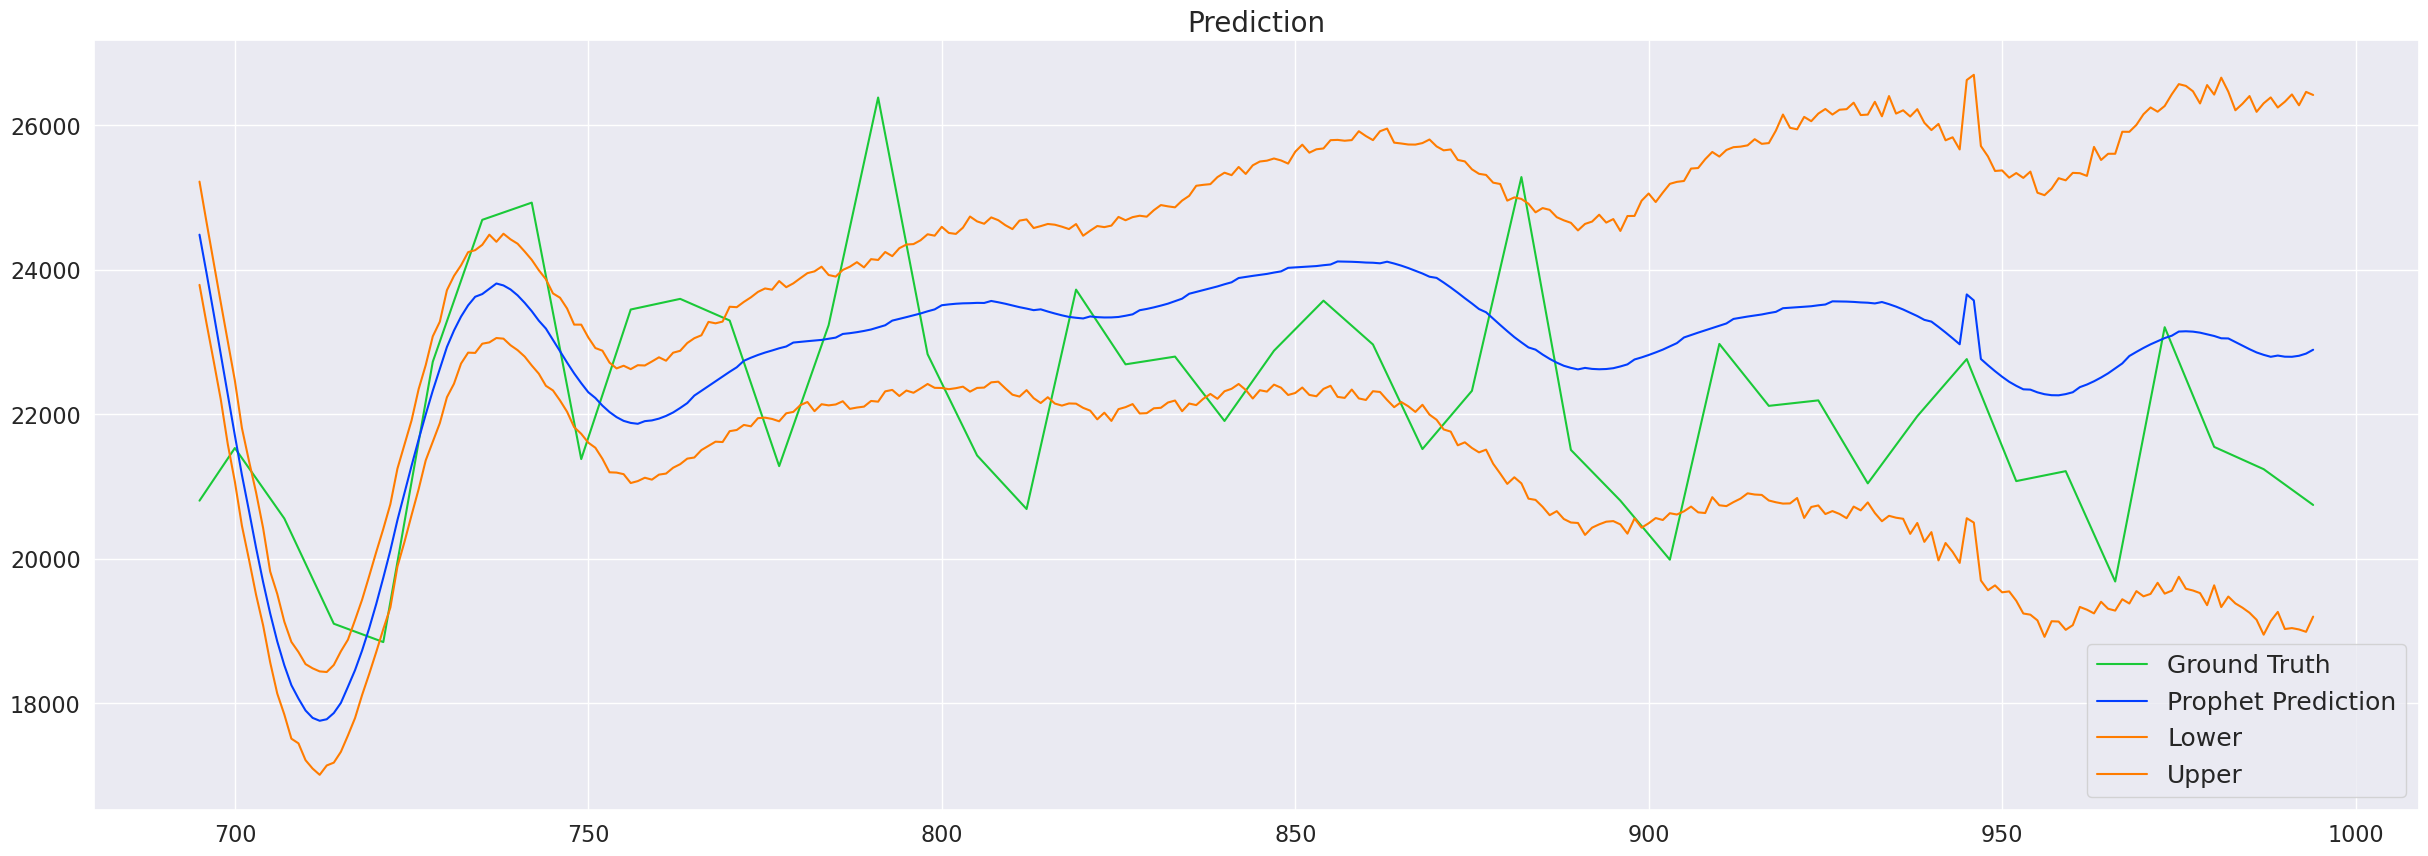

In [31]:
plt.plot(walmart_store_one['Weekly_Sales'][695:], color=colors[2], label='Ground Truth')
plt.plot(prediction['yhat'][695:], color=colors[0], label='Prophet Prediction')
plt.plot(prediction['yhat_lower'][695:], color=colors[1], label='Lower')
plt.plot(prediction['yhat_upper'][695:], color=colors[1], label='Upper')
plt.title('Prediction')
plt.legend(loc='best')
plt.show()

### Check Model Performance

In [32]:
performance = pd.DataFrame()
performance['y_true'] = walmart_store_one['Weekly_Sales'][695:]
performance['y_pred'] = prediction['yhat'][695:]
performance['yhat_lower'] = prediction['yhat_lower'][695:]
performance['yhat_upper'] = prediction['yhat_upper'][695:]
# Check MAE value
performance_MAE = mean_absolute_error(performance['y_true'], performance['y_pred'])
print(f'The MAE for the model is {performance_MAE}')
# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(performance['y_true'], performance['y_pred'])
print(f'The MAPE for the model is {performance_MAPE}')

The MAE for the model is 1264.3411800406348
The MAPE for the model is 0.057805813908399985


### Anomaly Detection

In [34]:
performance['error'] = performance['y_true'] - performance['y_pred']
performance['uncertanity'] = performance['yhat_upper'] - performance['yhat_lower']

In [35]:
performance[performance['error'].abs() > 1.5*performance['uncertanity']]

,y_true,y_pred,yhat_lower,yhat_upper,error,uncertanity
695,20804.538691,24485.953097,23791.364735,25220.249223,-3681.414406,1428.884489
696,20950.214064,23952.228645,23255.429249,24655.978749,-3002.014581,1400.549500
697,21095.889437,23399.701165,22739.190173,24100.928308,-2303.811729,1361.738136
707,20557.762958,18526.165756,17844.696280,19129.496469,2031.597202,1284.800189
708,20349.694747,18250.459688,17510.115495,18849.485107,2099.235059,1339.369612
709,20141.626535,18065.763215,17445.763726,18709.657910,2075.863320,1263.894185
710,19933.558324,17900.704562,17212.883973,18542.541704,2032.853763,1329.657730
791,26384.401111,23202.831560,22174.941753,24136.214640,3181.569551,1961.272887


In [36]:
performance['anomaly'] = performance.apply(lambda x: 'Yes' if(np.abs(x['error'] > 1.5 * x['uncertanity'])) else 'No', axis=1)

In [37]:
performance['anomaly'].value_counts()

No     295
Yes      5
Name: anomaly, dtype: int64

In [38]:
performance[performance['anomaly'] == 'Yes']

,y_true,y_pred,yhat_lower,yhat_upper,error,uncertanity,anomaly
707,20557.762958,18526.165756,17844.696280,19129.496469,2031.597202,1284.800189,Yes
708,20349.694747,18250.459688,17510.115495,18849.485107,2099.235059,1339.369612,Yes
709,20141.626535,18065.763215,17445.763726,18709.657910,2075.863320,1263.894185,Yes
710,19933.558324,17900.704562,17212.883973,18542.541704,2032.853763,1329.657730,Yes
791,26384.401111,23202.831560,22174.941753,24136.214640,3181.569551,1961.272887,Yes


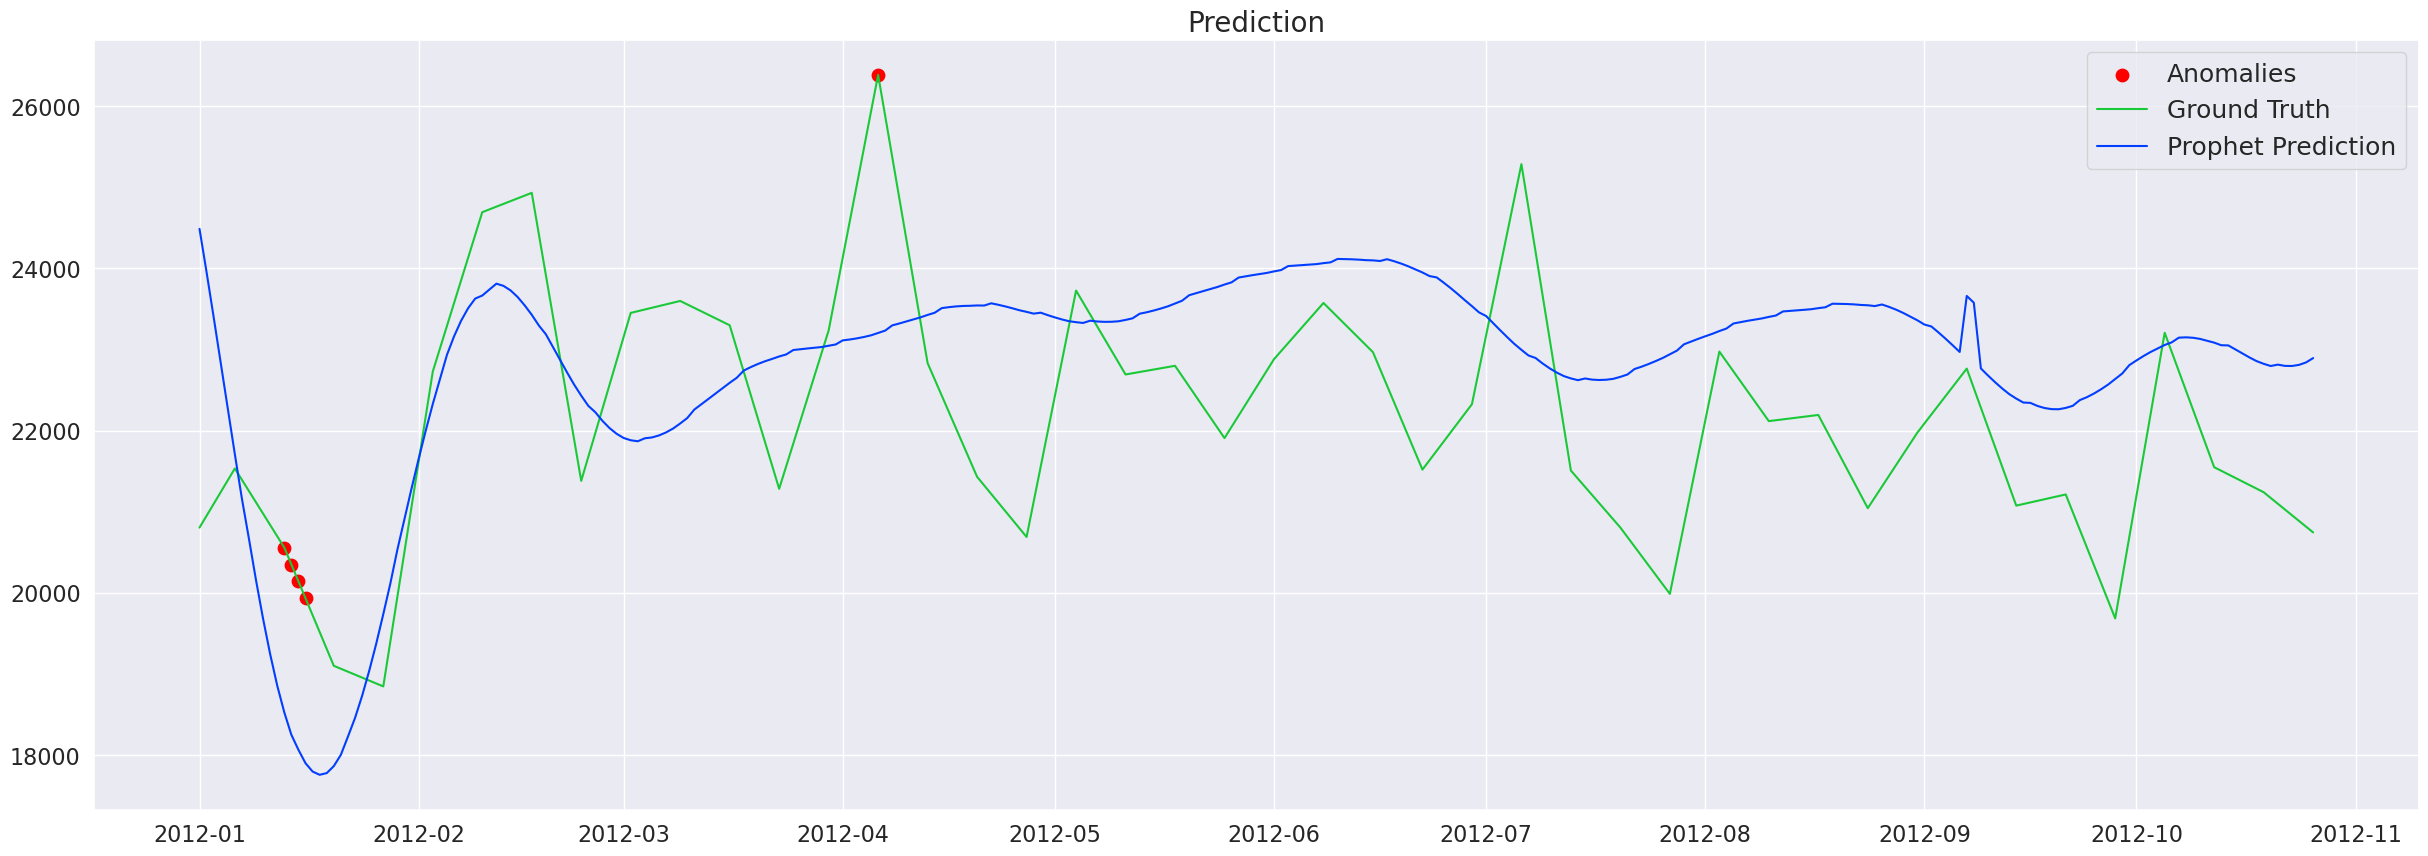

In [90]:
mask = performance['anomaly'] == 'Yes'

plt.scatter(walmart_store_one['Date'][695:][mask], performance['y_true'][mask], color='red', s=80, marker='o', label='Anomalies')
plt.plot(walmart_store_one['Date'][695:], walmart_store_one['Weekly_Sales'][695:], color=colors[2], label='Ground Truth')
plt.plot(walmart_store_one['Date'][695:], prediction['yhat'][695:], color=colors[0], label='Prophet Prediction')
plt.title('Prediction')
plt.legend(loc='best')
plt.show()

# ARIMA

In [40]:
walmart_store_one = walmart_store_one.drop(['Year'], axis=1)
walmart_store_one.head()

,Date,Weekly_Sales
0,2010-02-05,22516.313699
1,2010-02-06,22557.549519
2,2010-02-07,22598.785340
3,2010-02-08,22640.021161
4,2010-02-09,22681.256982


### Train/Test Split

In [42]:
walmart_store_one_train = walmart_store_one['Weekly_Sales'][:695]
walmart_store_one_test = walmart_store_one['Weekly_Sales'][695:]

walmart_store_one_train_log = np.log10(walmart_store_one_train)
walmart_store_one_test_log = np.log10(walmart_store_one_test)

my_order = (0, 1, 0)
my_seasonal_order = (0, 1, 0, 7)

In [43]:
history = [x for x in walmart_store_one_train_log]
predictions = list()
predict_log=list()

In [44]:
for t in range(len(walmart_store_one_test_log)):
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])

    yhat = 10**output[0]
    predictions.append(yhat)

    obs = walmart_store_one_test_log[t+695]
    history.append(obs)

/home/zobby/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/zobby/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/zobby/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/zobby/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/zobby/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/zobby/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization f

In [45]:
predictions_df = pd.DataFrame(predictions, columns=['arima_predictions'])

In [46]:
predictions_df.index = range(695, 995)

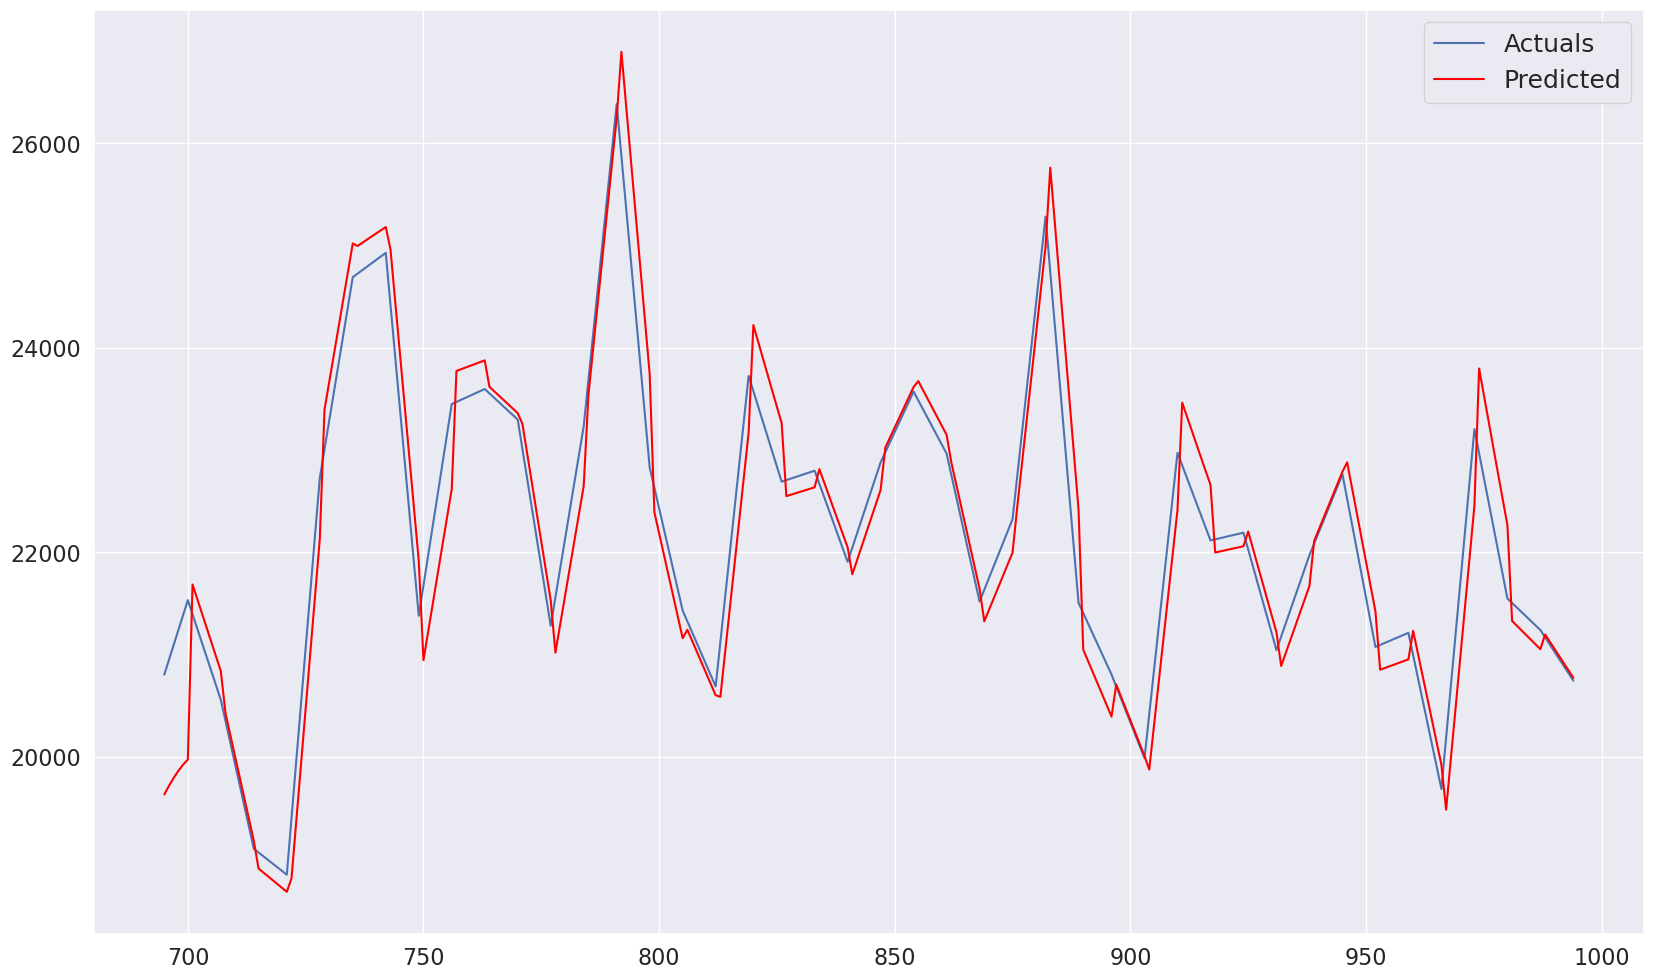

In [47]:
figsize=(20, 12)
plt.figure(figsize=figsize)
plt.plot(walmart_store_one_test, label='Actuals')
plt.plot(predictions_df['arima_predictions'], color='red',label='Predicted')
plt.legend(loc='upper right')
plt.show()

In [49]:
predicted_df=pd.DataFrame()

predicted_df['Date']=walmart_store_one['Date'][695:]
predicted_df['actuals']=walmart_store_one_test
predicted_df['predicted']=predictions_df['arima_predictions']

predicted_df.reset_index(inplace=True)
del predicted_df['index']
predicted_df.head()

,Date,actuals,predicted
0,2012-01-01,20804.538691,19632.392617
1,2012-01-02,20950.214064,19716.783291
2,2012-01-03,21095.889437,19794.410878
3,2012-01-04,21241.564810,19864.092695
4,2012-01-05,21387.240183,19924.348830


In [50]:
predicted_df.shape

(300, 3)

### Anomaly Detection

In [52]:
window = 7
predicted_df.replace([np.inf, -np.inf], np.NaN, inplace=True)
predicted_df.fillna(0,inplace=True)

predicted_df['meanval'] = predicted_df['actuals'].rolling(window=window).mean()
predicted_df['deviation'] = predicted_df['actuals'].rolling(window=window).std()
predicted_df['error']=predicted_df['actuals']-predicted_df['predicted']
predicted_df['percentage_change'] = ((predicted_df['actuals'] - predicted_df['predicted']) / predicted_df['actuals']) * 100

predicted_df['-3s'] = predicted_df['meanval'] - (2 * predicted_df['deviation'])
predicted_df['3s'] = predicted_df['meanval'] + (2 * predicted_df['deviation'])
predicted_df['-2s'] = predicted_df['meanval'] - (1.75 * predicted_df['deviation'])
predicted_df['2s'] = predicted_df['meanval'] + (1.75 * predicted_df['deviation'])
predicted_df['-1s'] = predicted_df['meanval'] - (1.5 * predicted_df['deviation'])
predicted_df['1s'] = predicted_df['meanval'] + (1.5 * predicted_df['deviation'])

In [53]:
predicted_df.head()

,Date,actuals,predicted,meanval,deviation,error,percentage_change,-3s,3s,-2s,2s,-1s,1s
0,2012-01-01,20804.538691,19632.392617,NaN,NaN,1172.146074,5.634088,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,20950.214064,19716.783291,NaN,NaN,1233.430773,5.887438,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-03,21095.889437,19794.410878,NaN,NaN,1301.478559,6.169347,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-04,21241.564810,19864.092695,NaN,NaN,1377.472114,6.484796,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-05,21387.240183,19924.348830,NaN,NaN,1462.891352,6.840019,NaN,NaN,NaN,NaN,NaN,NaN


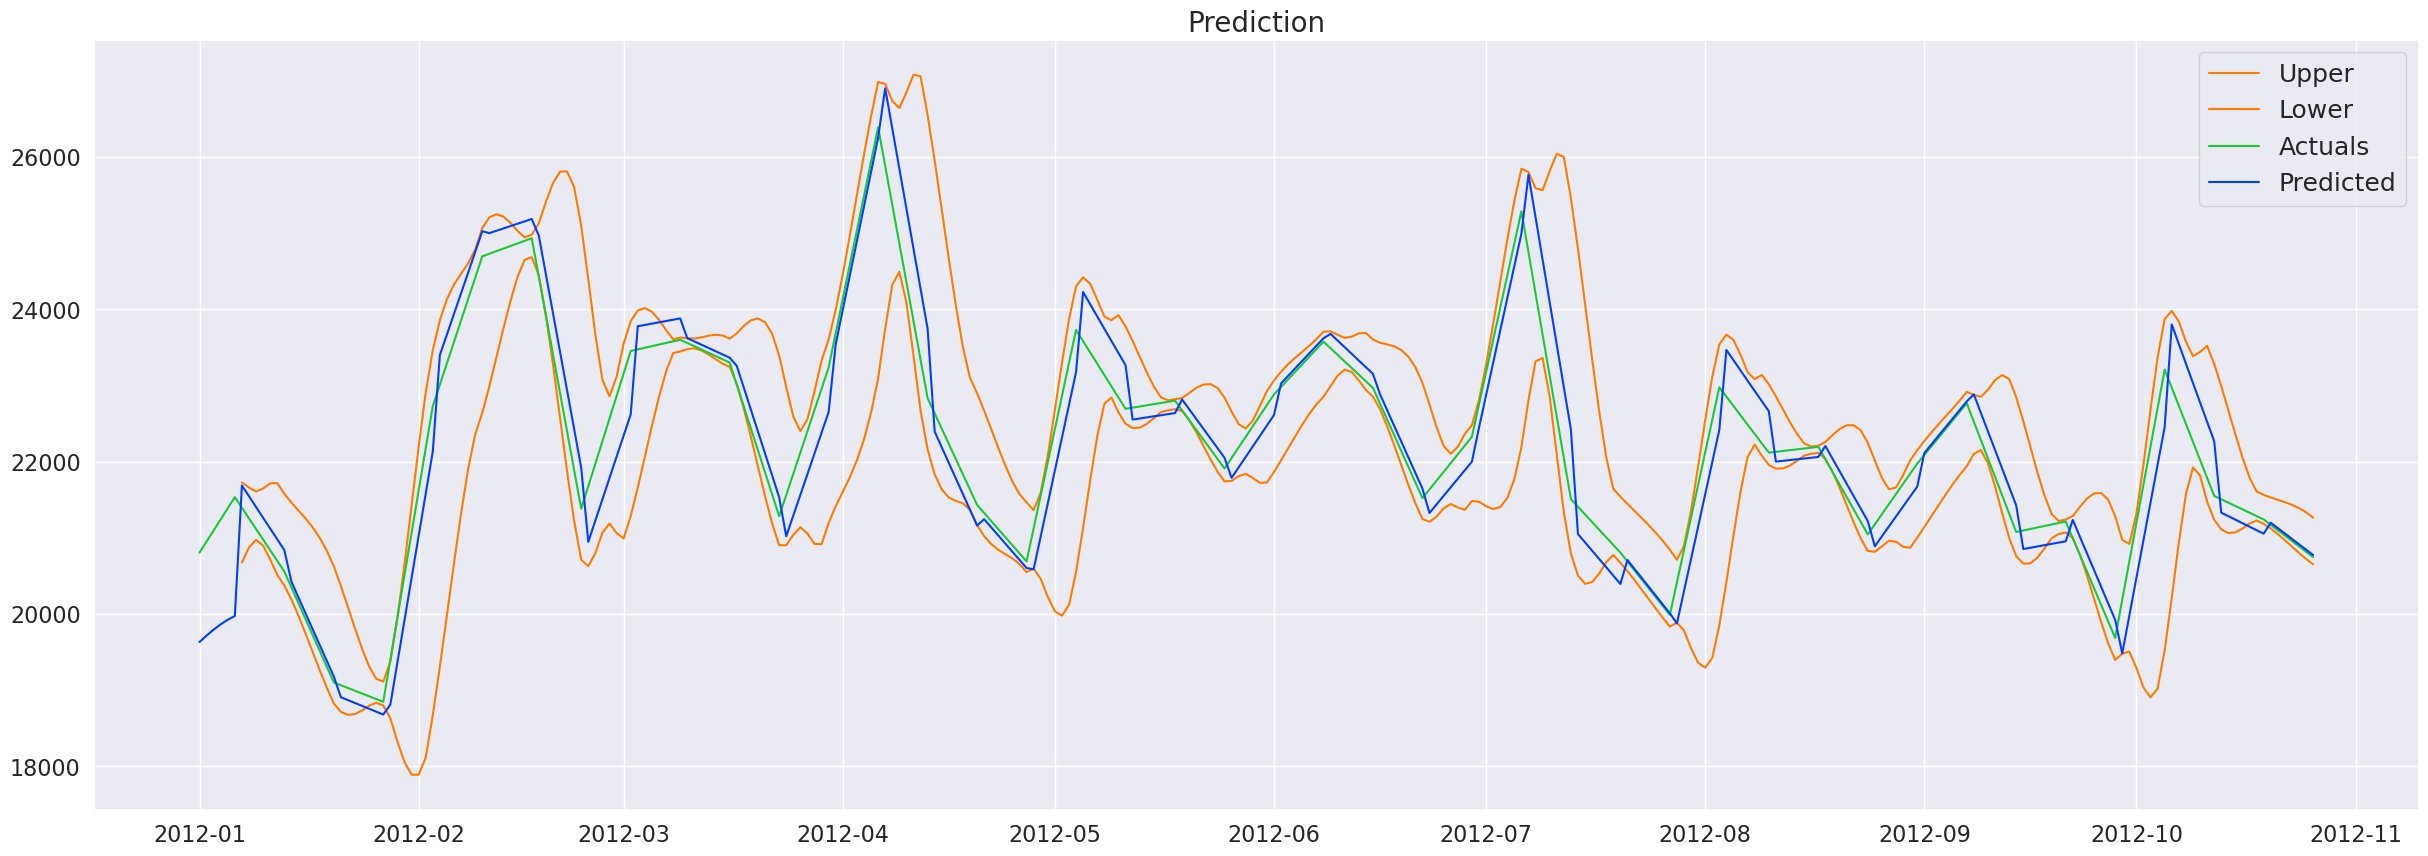

In [63]:
dates = predicted_df['Date']
# Upper Bound and Lower Bound
plt.plot(dates, predicted_df['3s'], color=colors[1], label='Upper')
plt.plot(dates, predicted_df['-3s'], color=colors[1], label='Lower')
# Actuals
plt.plot(dates, predicted_df['actuals'], color=colors[2], label='Actuals')
# Predicted
plt.plot(dates, predicted_df['predicted'], color=colors[0], label='Predicted')
plt.title('Prediction')
plt.legend(loc='upper right')
plt.show()

In [59]:
predicted_df['uncertanity'] = predicted_df['3s'] - predicted_df['-3s']
predicted_df['anomaly'] = predicted_df.apply(lambda x: 'Yes' if(np.abs(x['error'] > 1.5*x['uncertanity'])) else 'No', axis=1)
predicted_df['anomaly'].value_counts()

No     298
Yes      2
Name: anomaly, dtype: int64

In [60]:
predicted_df[predicted_df['anomaly'] == 'Yes']

,Date,actuals,predicted,meanval,deviation,error,percentage_change,-3s,3s,-2s,2s,-1s,1s,uncertanity,anomaly
263,2012-09-20,21193.379938,20936.795837,21134.390455,42.477282,256.584100,1.210680,21049.435890,21219.345020,21060.055211,21208.725699,21070.674531,21198.106379,169.90913,Yes
264,2012-09-21,21213.043099,20953.555473,21154.053616,42.477282,259.487626,1.223246,21069.099051,21239.008181,21079.718372,21228.388860,21090.337692,21217.769539,169.90913,Yes


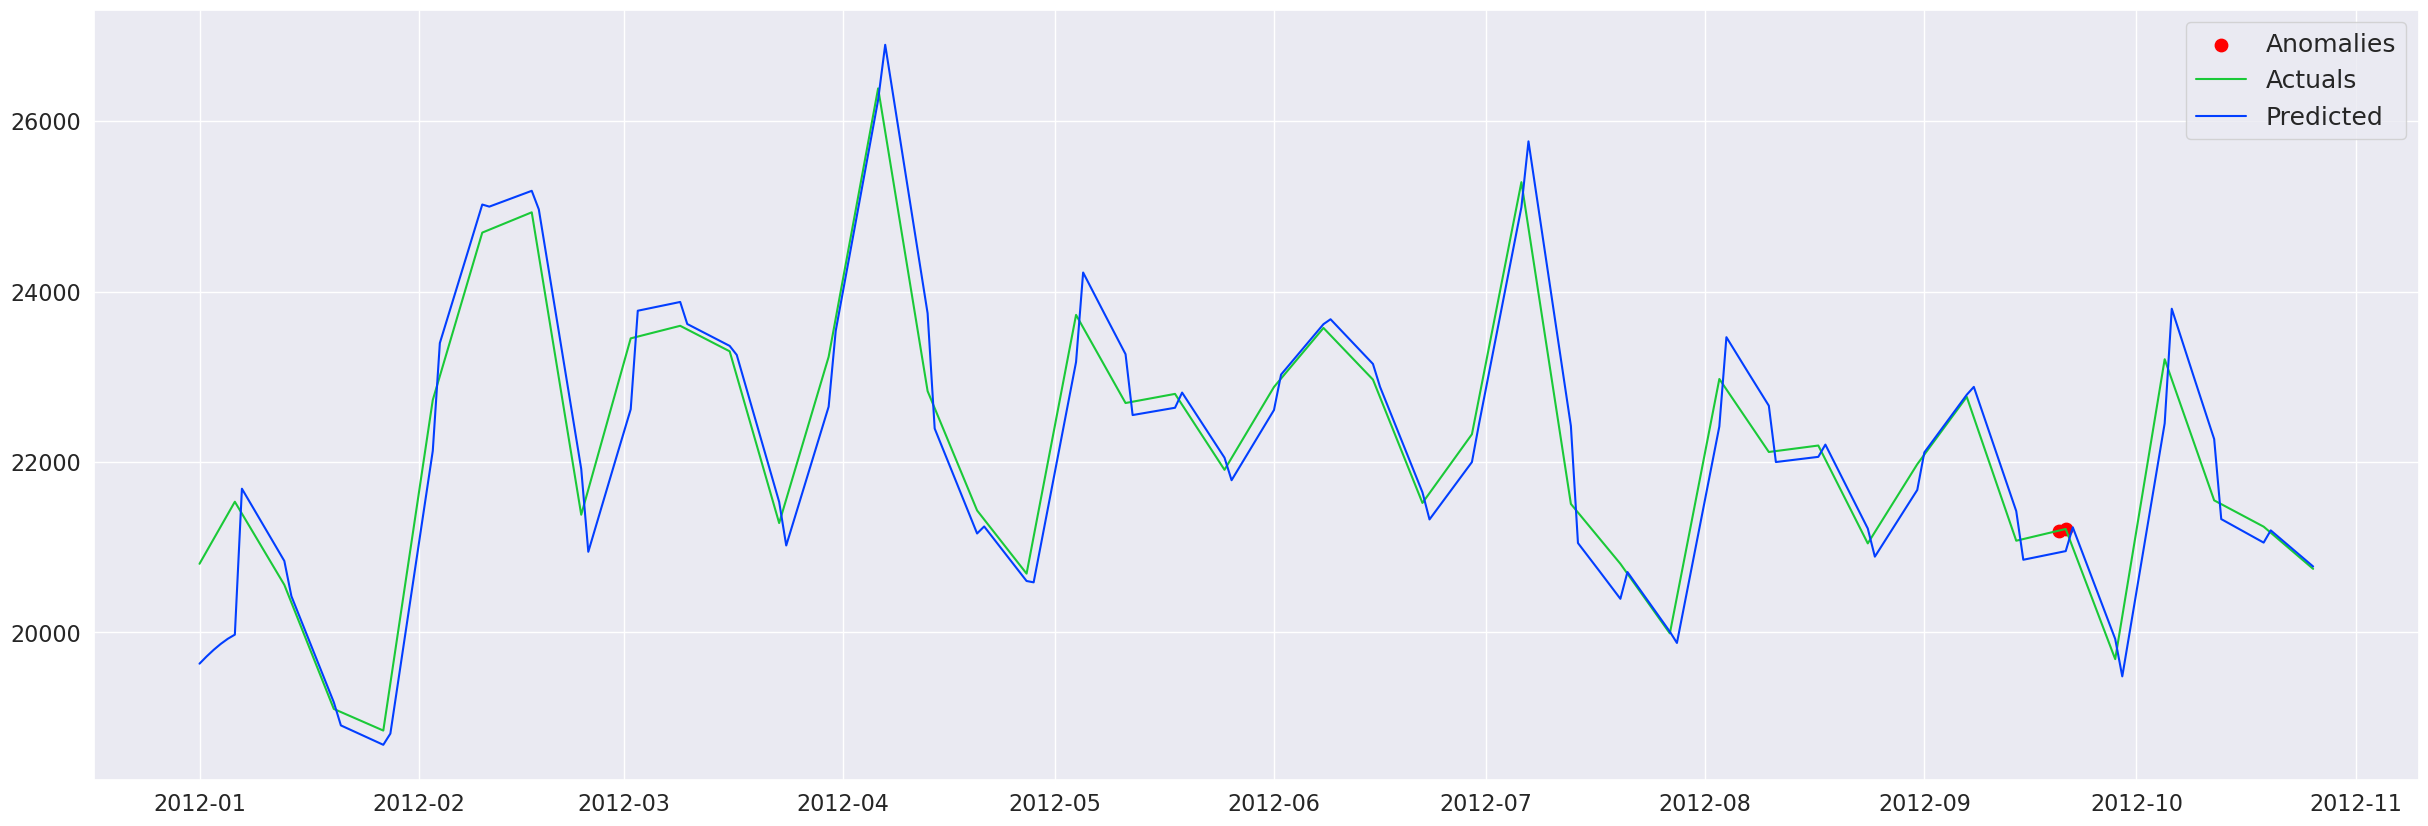

In [73]:
mask = predicted_df['anomaly'] == 'Yes'
plt.scatter(dates[mask], predicted_df['actuals'][mask], color='red', s=80, marker='o', label='Anomalies')
# Actuals
plt.plot(dates, predicted_df['actuals'], color=colors[2], label='Actuals')
# Predicted
plt.plot(dates, predicted_df['predicted'], color=colors[0], label='Predicted')
plt.legend(loc='upper right')
plt.show()